# Neural Machine Translation with Seq2Seq + Attention

#### A sequence-to-sequence model that translates Italian sentences into English using an encoder-decoder architecture with attention mechanism with different scoring methods.

This project was inspired by Encoder-Decoder with Attention. The goal was to turn it into a real-world application and learning exercise in NLP with deep learning.

## Dataset
This project uses the Italian-English sentence pair dataset from [ManyThings.org](http://www.manythings.org/anki/ita-eng.zip), a widely used resource for training small-scale machine translation models. The dataset consists of aligned sentence pairs and is suitable for sequence-to-sequence training and evaluation.

## Evaluation Metric
- BLEU score for translation quality
- Optional: accuracy on a validation set or attention visualization


## Workflow Overview
1. Data preprocessing (cleaning, tokenizing)
2. Model building (encoder, decoder)
3. Training loop
4. Evaluation
5. Inference (translate new sentences)
6. build the attention layer and do the same steps 2. 3. 4. 5. 
7. Visualization (attention heatmaps)
8. Use different scoring methods and show results

## Implementation

### 1. Data preprocessing

#### 1.1 Importing libraries

In [1]:
#removing warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

In [2]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
# Data Handling
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
# Neural Network
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization
from tensorflow.keras.models import Model
#preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Model saving and loading and logging
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
# Evaluation
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

2025-05-10 11:57:07.877436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746867428.000065    2309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746867428.032442    2309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746867428.301811    2309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746867428.301843    2309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746867428.301845    2309 computation_placer.cc:177] computation placer alr

#### 1.2 Loading the data

In [3]:
# opening the text file and storing it in dataframe

# Path to the dataset (from http://www.manythings.org/anki/)
file_path = 'ita.txt'

with open(file_path, 'r', encoding="utf8") as f:
    #initializing lists for each language
    eng=[]
    ita=[]
    #reading line by line and appending
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
        
# storing in dataframe
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
# show dataset shape and preview
print(data.shape)
data.head()

(377937, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


#### 1.3 preprocessing the data

In [4]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form."""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters, remove contractions and special characters except space
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these special characters with space: '\u200b', '\xa0', '-', '/'

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text

# applying the preprocessing functions
data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)

#preview
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [5]:
# Create a copy of the original DataFrame to safely perform preprocessing
# (Avoids the potential issues of modifying a view from a slice of the original data)
filtered_data = data.copy()

# Filter out sentence pairs where either sentence has 20 words or more
# This helps keep training manageable and avoids long input sequences
filtered_data['italian_len'] = filtered_data['italian'].str.split().apply(len)
filtered_data = filtered_data[filtered_data['italian_len'] < 20]

filtered_data['english_len'] = filtered_data['english'].str.split().apply(len)
filtered_data = filtered_data[filtered_data['english_len'] < 20]

# Add special tokens for the encoder and decoder
# These tokens mark the beginning and end of a sentence to sequence models
filtered_data['english_inp'] = '<start> ' + filtered_data['english'].astype(str)
filtered_data['english_out'] = filtered_data['english'].astype(str) + ' <end>'

# Drop columns that are no longer needed
filtered_data = filtered_data.drop(['english', 'italian_len', 'english_len'], axis=1)

# Replace the original dataset with the cleaned and formatted version
data = filtered_data
#preview
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [6]:
# Splitting the data for training the model and testing it
train, validation = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# Reseting the index for easier slicing and consistent row access
train = train.reset_index(drop=True)
validation = validation.reset_index(drop = True)

# Add <end> token to the first sentence manually
# This helps the tokenizer learn the <end> token during fitting
# By doing this early, we ensure that a single tokenizer can be used
# for both the decoder's input and target sequences
train.loc[0, 'english_inp'] = str(train.loc[0, 'english_inp']) + ' <end>'

In [8]:
# Initialising the Italian tokenizer (input language)
tknizer_ita = Tokenizer()
#Learning the vocabulary of the italian sentences
tknizer_ita.fit_on_texts(train['italian'].values)
# Initialising the English tokenizer (target language)
# Custom filters are used to remove special characters and punctuation
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
#Learning the vocabulary of the English sentences (with <start> token)
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [9]:
# Storing the length of the two tokenizers for future use
vocab_size_eng=len(tknizer_eng.word_index.keys())
vocab_size_ita=len(tknizer_ita.word_index.keys())

print(f"Italian vocab size: {len(tknizer_ita.word_index) + 1}")
print(f"English vocab size: {len(tknizer_eng.word_index) + 1}")

Italian vocab size: 27478
English vocab size: 13426


##### [glove.6B.100d Used](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.100d.txt)

In [10]:
# Load pre-trained GloVe embeddings and create an embedding matrix for English vocabulary
# This is used for initializing the vector of English sentences during fitting the model
# Creating empty dictionary to fill it such that each key is a word and value is the vector
embeddings_index = dict()
# Path to GloVe embedding file (e.g., 100-dimensional vectors)
glove_path = 'glove.6B.100d.txt'
#opening the text file
f = open(glove_path, encoding='utf-8')
#looping over every line
for line in f:
    #splitting the line to access each word and it's corresponding vector
    values = line.split()
    # Storing the word and it's correspond vector and saving it in the empty dictionary created earlier
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Initialize an embedding matrix where each row corresponds to a word in the tokenizer
embedding_matrix = np.zeros((vocab_size_eng+1, 100))
#looping over the words in the tokenizer
for word, i in tknizer_eng.word_index.items():
    #getting the word from the embeddings_index dictionary filled earlier
    embedding_vector = embeddings_index.get(word)
    #if it exist in the english tokenizer, added it to the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
#length of the matrix
#same as English vocab size
len(embedding_matrix)

13426

### 2. Model building (encoder, decoder)

In [12]:
class Encoder(tf.keras.Model):
    '''
    Encoder model for sequence-to-sequence translation.

    Takes an input sequence and returns:
    - Encoder LSTM outputs (lstm_output)
    - Final hidden state (state_h)
    - Final cell state (state_c)
    '''

    def __init__(self, vocab_size, embedding_dim, enc_units, input_length, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size          # Size of the input vocabulary
        self.embedding_dim = embedding_dim    # Dimensionality of embedding vectors
        self.enc_units = enc_units            # Number of LSTM units
        self.input_length = input_length      # Maximum input sequence length


    def build(self, input_shape):
        # Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size + 1,
                                   output_dim=self.embedding_dim,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name="embedding_layer_encoder")

        # LSTM layer: returns full sequence and final hidden/cell states
        self.lstm = LSTM(self.enc_units,
                         return_state=True,
                         return_sequences=True,
                         use_cudnn=False,
                         name="Encoder_LSTM")

    def call(self, input_sequence):

        # Convert input tokens to embeddings
        input_embedd = self.embedding(input_sequence)
        mask = self.embedding.compute_mask(input_sequence)

        
        # Pass through LSTM
        lstm_output, state_h, state_c = self.lstm(input_embedd, mask=mask)
        return lstm_output, state_h, state_c



    def initialize_states(self,batch_size):
      '''
      Returns zero-initialized hidden and cell states for a given batch size.
      '''
      return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]

    def get_states(self):
        '''
        Return the last LSTM hidden and cell states (if needed externally).
        '''
        return self.lstm_state_h,self.lstm_state_c

In [13]:
class Decoder(tf.keras.Model):
    '''
    Decoder model for sequence-to-sequence translation.

    Takes an input sequence and returns:
    - Decoder LSTM outputs (lstm_output)
    - Final hidden state (state_h)
    - Final cell state (state_c)
    '''

    def __init__(self, out_vocab_size, embedding_dim, dec_units, input_length, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = out_vocab_size             # Size of the input vocabulary
        self.embedding_dim = embedding_dim           # Dimensionality of embedding vectors
        self.dec_units = dec_units                   # Number of LSTM units
        self.input_length = input_length             # Maximum input sequence length



    def build(self, input_shape):
        # Embedding layer, same dimensionality as Glove Vector
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size + 1,
                                   output_dim=self.embedding_dim,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name="embedding_layer_decoder",
                                   weights=[embedding_matrix],
                                   trainable=False)
        
        # LSTM layer: returns full sequence and final hidden/cell states
        self.lstm = LSTM(self.dec_units,
                         return_sequences=True,
                         return_state=True,
                         use_cudnn=False,
                         name="Decoder_LSTM",
                        )


    def call(self,input_sequence,initial_states):
        # Convert input tokens to embeddings
        target_embedd= self.embedding(input_sequence)
        #manually getting the mask just to make sure it's going through
        mask = self.embedding.compute_mask(input_sequence)
        # Pass through LSTM
        lstm_output, state_h, state_c = self.lstm(target_embedd, initial_state=initial_states, mask=mask)
        return lstm_output, state_h, state_c

In [14]:
class Encoder_decoder(tf.keras.Model):
    """
    Combined Encoder-Decoder model for sequence-to-sequence translation.

    Uses an encoder to process the input sequence and a decoder to generate
    the output sequence, followed by a dense softmax layer to predict tokens.
    """
    
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size, **kwargs):
        super().__init__(**kwargs)
        
        self.encoder_inputs_length = encoder_inputs_length           # encoder input sequence length
        self.decoder_inputs_length = decoder_inputs_length           # decoder input sequence length
        self.output_vocab_size = output_vocab_size                   # output length

        # Initialize Encoder
        self.encoder = Encoder(vocab_size=vocab_size_ita, embedding_dim=50,
                               input_length=encoder_inputs_length, enc_units=256)
        # Initialize Decoder
        self.decoder = Decoder(out_vocab_size=vocab_size_eng, embedding_dim=100,
                               input_length=decoder_inputs_length, dec_units=256)
        # Final dense layer to convert decoder outputs into vocabulary probabilities
        self.dense = Dense(output_vocab_size + 1, activation='softmax')

    def call(self, inputs, training=None):
        """
        Forward pass through the model.
        
        Args:
            inputs: Tuple of (encoder_input, decoder_input)
            training: Not used, included for compatibility

        Returns:
            output: Softmax probabilities over the output vocabulary
        """
        
        # getting the inputs of both encoder, decoder to pass it through
        encoder_input, decoder_input = inputs

        # Pass inputs through encoder
        encoder_output, state_h, state_c = self.encoder(encoder_input)

        # Pass encoder states to the decoder
        decoder_output, _, _ = self.decoder(decoder_input, [state_h, state_c])

        # Final output layer to get token probabilities
        output = self.dense(decoder_output)
        return output

In [13]:
# using tf.data api to batch the data and run it during fitting
# useful for slicing and speed
def create_dataset_with_padding(encoder_texts, decoder_texts_inp, decoder_texts_out, batch_size):
    # Tokenize and pad all sequences
    # transforming text into vector to get the tokens
    encoder_inputs = tknizer_ita.texts_to_sequences(encoder_texts)
    decoder_inputs = tknizer_eng.texts_to_sequences(decoder_texts_inp)  # <start> sentence
    decoder_outputs = tknizer_eng.texts_to_sequences(decoder_texts_out) # sentence <end>

    # padding all sequence to make it same length
    encoder_inputs = pad_sequences(encoder_inputs, padding='post')
    decoder_inputs = pad_sequences(decoder_inputs, maxlen=20, padding='post')
    decoder_outputs = pad_sequences(decoder_outputs, maxlen=20, padding='post')

    # getting the slices of the data
    dataset = tf.data.Dataset.from_tensor_slices((
        (encoder_inputs, decoder_inputs),
        decoder_outputs
    ))
    # return the slice with shuffeling and custom batch size
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
# using the function for training
ds_train = create_dataset_with_padding(train.italian.values, train.english_inp.values,
                                       train.english_out.values, 256)

I0000 00:00:1746779339.917484     608 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6


In [15]:
def create_validation_dataset(encoder_texts, decoder_texts_inp, decoder_texts_out, batch_size):
    # Use the SAME tokenizers and padding as training
    # Tokenize and pad all sequences
    encoder_inputs = tknizer_ita.texts_to_sequences(encoder_texts)
    decoder_inputs = tknizer_eng.texts_to_sequences(decoder_texts_inp)  # <start> sentence
    decoder_outputs = tknizer_eng.texts_to_sequences(decoder_texts_out) # sentence <end>

    encoder_inputs = pad_sequences(encoder_inputs, padding='post')
    decoder_inputs = pad_sequences(decoder_inputs, maxlen=20, padding='post')
    decoder_outputs = pad_sequences(decoder_outputs, maxlen=20, padding='post')

    dataset = tf.data.Dataset.from_tensor_slices((
        (encoder_inputs, decoder_inputs),
        decoder_outputs
    ))
    
    # Only difference: Don't shuffle the validation data
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
# using the function for validating
ds_validate = create_validation_dataset(validation.italian.values, validation.english_inp.values,
                                       validation.english_out.values, 256)

### 3. Training Loop

In [19]:
#initializing the seq-to-seq model
model = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)

In [17]:
# define custom masked_loss to get the loss only on actually predicted words not the padding
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [18]:
# define custom masked accuracy to get the accuracy only on actually predicted words not the padding
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)


In [24]:
# Compile the model and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer,loss=masked_loss,metrics=[masked_acc])

In [28]:
# using checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # or 'best_model.h5'
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
# Using logger callback for plotting
csv_logger = CSVLogger('training_log.csv', append=False)

In [26]:
# fitting the model
model.fit(ds_train,
          epochs=30,
          validation_data=ds_validate,
          verbose = 1,
          callbacks=[checkpoint, csv_logger])

Epoch 1/30


/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746710138.311468    8528 service.cc:152] XLA service 0x7fcfe00040a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746710138.311501    8528 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1746710138.761967    8528 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746710146.259191    8528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1180/1180 ━━━━━━━━━━━━━━━━━━━━ 127s 98ms/step - loss: 5.2748 - masked_acc: 0.2186 - val_loss: 3.8011 - val_masked_acc: 0.3637
Epoch 2/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 107s 90ms/step - loss: 3.5535 - masked_acc: 0.3966 - val_loss: 2.9157 - val_masked_acc: 0.4827
Epoch 3/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 108s 92ms/step - loss: 2.7498 - masked_acc: 0.5034 - val_loss: 2.3506 - val_masked_acc: 0.5564
Epoch 4/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - loss: 2.1899 - masked_acc: 0.5781 - val_loss: 1.9327 - val_masked_acc: 0.6190
Epoch 5/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - loss: 1.7689 - masked_acc: 0.6415 - val_loss: 1.6332 - val_masked_acc: 0.6687
Epoch 6/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 70s 59ms/step - loss: 1.4548 - masked_acc: 0.6931 - val_loss: 1.4228 - val_masked_acc: 0.7052
Epoch 7/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - loss: 1.2261 - masked_acc: 0.7329 - val_loss: 1.2753 - val_masked_acc: 0.7319
Epoch 8/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 69s 59ms/step 

In [32]:
# saving the model for later use
model.save_weights("model.weights.h5")

In [25]:
# loading the model if needed
# Re-create the model structure
model = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)

# Build the model by calling it once with dummy data
dummy_encoder_input = tf.random.uniform((1, 20), dtype=tf.int32,  minval=0, maxval=100)
dummy_decoder_input = tf.random.uniform((1, 20), dtype=tf.int32,  minval=0, maxval=100)
_ = model([dummy_encoder_input, dummy_decoder_input])

# 3. Load weights
model.load_weights("model.weights.h5")

/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 4. Evaluation

In [34]:
def predict(input_sentence,max_len = 20):
    # 1. Preprocess the input sentence by converting to vector and padding
    input_seq = tknizer_ita.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')

    # 2. Encode the input sequence
    enc_out, state_h, state_c = model.encoder(tf.convert_to_tensor(input_seq))

    # 3. Prepare decoder input (start with <sos> token)
    sos_token = tknizer_eng.word_index.get('<start>', 1)  # fallback to 1 if not found
    eos_token = tknizer_eng.word_index.get('<end>', 2)  # optional: for stopping
    target_seq = tf.expand_dims([sos_token], 0)  # add dimension to match

    # final sentence stored in a list
    decoded_sentence = []

    #looping over sentence length
    for _ in range(max_len):
        # Predict next token
        # getting the states then using output(predictions) to get the probabilities
        predictions, state_h, state_c = model.decoder(target_seq, [state_h, state_c])
        output_token_probs = model.dense(predictions)
        
        # Get predicted token (greedy)
        predicted_token = tf.argmax(output_token_probs[0, -1]).numpy()
        #getting the actual word
        predicted_word = tknizer_eng.index_word.get(predicted_token, '')

        # Break if <eos> is reached
        if predicted_token == eos_token or predicted_word == '':
            break

        # Adding predicted word to the list
        decoded_sentence.append(predicted_word)

        # Update target_seq with predicted token to predict next word
        target_seq = tf.expand_dims([predicted_token], 0)
    #converting list to sentence and returning it
    return ' '.join(decoded_sentence)

In [53]:
# smoothing function for Bleu score
smoothie = SmoothingFunction().method4

In [35]:
# getting 1000 values and taking the average Bleu
bleu_increment = 0
for row in validation[:1000].values:
    reference = row[2][:-6] # the original
    translation = predict(row[0]) # traslated using model
    reference_tokens = reference.split()         # original tokens for bleu
    translation_tokens = translation.split()     # translated tokens for bleu

    #getting the bleu score
    bleu_score = sentence_bleu([reference_tokens], translation_tokens, smoothing_function=smoothie)
    #increment it to get average
    bleu_increment += bleu_score
    #Bleu score for the sentece
    print('BLEU score:', bleu_score)

BLEU score: 1.0
BLEU score: 0.16821895003341453
BLEU score: 0.07517081801936397
BLEU score: 0.668740304976422
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.02302676613984314
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 0.03784310341709043
BLEU score: 0.33602782883534926
BLEU score: 0.04871911135426937
BLEU score: 0.13427896671164932
BLEU score: 1.0
BLEU score: 0.08991803844670224
BLEU score: 1.0
BLEU score: 0.488923022434901
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 0.43146827293898643
BLEU score: 0.5623413251903491
BLEU score: 0.03235934848975789
BLEU score: 0.31762152032055835
BLEU score: 0.7788007830714049
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.12121093525642128
BLEU score: 1.0
BLEU score: 0.3403088515262244
BLEU score: 1.0
BLEU score: 0.033173907815632314
BLEU score: 1.0
BLEU score: 0.4111336169005197
BLEU score: 1.0
BLEU

In [36]:
print('average BLEU score: ', bleu_increment/1000)

average BLEU score:  0.608691322596523


In [29]:
# Load the CSVLogger output
history_df = pd.read_csv('training_log.csv')

# Shift epoch index to start from 1 (optional, for consistency with manual logs)
history_df['epoch'] = history_df.index + 1

In [58]:
def plot_training_history(history_df, acc_key='masked_acc', val_acc_key='val_masked_acc',
                          loss_key='loss', val_loss_key='val_loss'):
    '''
    Plot the training and validation accuracy and loss
    '''
    # Get the epoch
    epochs = history_df['epoch']

    # Get the figure size
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_df[loss_key], label='Training Loss')
    plt.plot(epochs, history_df[val_loss_key], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_df[acc_key], label='Training Accuracy')
    plt.plot(epochs, history_df[val_acc_key], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

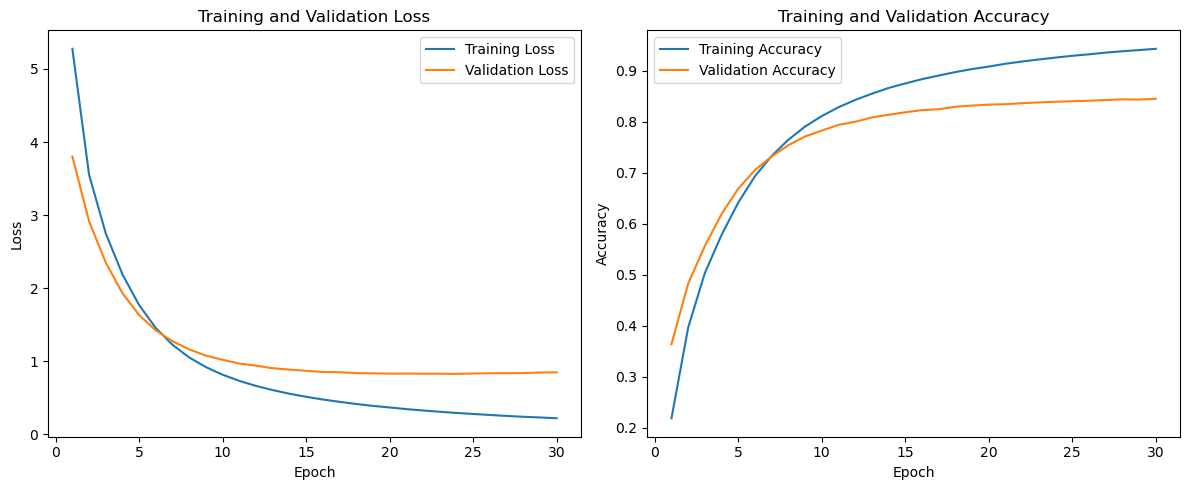

In [31]:
plot_training_history(history_df)

average Bleu score is 60.8%, good start for seq to seq model

### 5. Inference (translate new sentences)

In [37]:
# preview of test set
validation[10:]

,italian,english_inp,english_out
10,sono devastato,<start> i am devastated,i am devastated <end>
11,andiamo a sederci allombra,<start> let is go sit in the shade,let is go sit in the shade <end>
12,grazie per la sua pazienza,<start> thank you for your patience,thank you for your patience <end>
13,tom rassicurò mary,<start> tom reassured mary,tom reassured mary <end>
14,hanno guardato tutte,<start> they all looked,they all looked <end>
...,...,...,...
75481,tom fu lultimo a tornare,<start> tom was the last to return,tom was the last to return <end>
75482,io vorrei che non fosse così,<start> i wish it were not so,i wish it were not so <end>
75483,il tempo vola,<start> time flies,time flies <end>
75484,anche voi riuscite a farlo,<start> you can do it too,you can do it too <end>


In [40]:
#sentence translation
x = predict('anche voi riuscite a farlo')
print(x)

you can do it too


### 6. Build the attention layer and do the same steps 2. 3. 4. 5. with different scoring methods

#### Step 2: Model Building

In [33]:
#same Encoder created before, copied here for conveniency 
class Encoder(tf.keras.Model):
    '''
    Encoder model for sequence-to-sequence translation.

    Takes an input sequence and returns:
    - Encoder LSTM outputs (lstm_output)
    - Final hidden state (state_h)
    - Final cell state (state_c)
    '''

    def __init__(self, vocab_size, embedding_dim, enc_units, input_length, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size          # Size of the input vocabulary
        self.embedding_dim = embedding_dim    # Dimensionality of embedding vectors
        self.enc_units = enc_units            # Number of LSTM units
        self.input_length = input_length      # Maximum input sequence length


    def build(self, input_shape):
        # Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size + 1,
                                   output_dim=self.embedding_dim,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name="embedding_layer_encoder")

        # LSTM layer: returns full sequence and final hidden/cell states
        self.lstm = LSTM(self.enc_units,
                         return_state=True,
                         return_sequences=True,
                         use_cudnn=False,
                         name="Encoder_LSTM")

    def call(self, input_sequence):

        # Convert input tokens to embeddings
        input_embedd = self.embedding(input_sequence)
        mask = self.embedding.compute_mask(input_sequence)

        
        # Pass through LSTM
        lstm_output, state_h, state_c = self.lstm(input_embedd, mask=mask)
        return lstm_output, state_h, state_c



    def initialize_states(self,batch_size):
      '''
      Returns zero-initialized hidden and cell states for a given batch size.
      '''
      return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]

    def get_states(self):
        '''
        Return the last LSTM hidden and cell states (if needed externally).
        '''
        return self.lstm_state_h,self.lstm_state_c

In [34]:
class Attention(tf.keras.layers.Layer):
    '''
    Custom Attention Layer
    returns context vector and attention weights
    '''
    def __init__(self, scoring_function='dot', att_units=64):
        super(Attention, self).__init__()
        self.att_units = att_units    # Number of trainable attention units used for different scoring methods
        self.scoring_function = scoring_function    # Scoring funtion wanted
        # General scoring funtion from the research
        if scoring_function == 'general':
            self.W = tf.keras.layers.Dense(att_units)
        # Concatenation scoring funtion from the research
        elif scoring_function == 'concat':
            self.W1 = tf.keras.layers.Dense(att_units)
            self.W2 = tf.keras.layers.Dense(att_units)
            self.V = tf.keras.layers.Dense(1)

    def call(self, state_h_dec, enc_out):
        """
        state_h_dec: (batch_size, hidden_dim)
        enc_out: (batch_size, time_steps, hidden_dim)
        """

        # Expand state_h_dec to (batch_size, 1, hidden_dim)
        state_h_dec_expanded = tf.expand_dims(state_h_dec, 1)

        if self.scoring_function == 'dot':
            # Dot product
            score = tf.reduce_sum(enc_out * state_h_dec_expanded, axis=-1)  # (batch_size, time_steps)

        elif self.scoring_function == 'general':
            # Apply W on enc_out first
            transformed_enc_out = self.W(enc_out)  # (batch_size, time_steps, att_units)
            score = tf.reduce_sum(transformed_enc_out * state_h_dec_expanded, axis=-1)  # (batch_size, time_steps)

        elif self.scoring_function == 'concat':
            # W1(state) + W2(encoder_output)
            score = self.V(tf.nn.tanh(self.W1(state_h_dec_expanded) + self.W2(enc_out)))  # (batch_size, time_steps, 1)
            score = tf.squeeze(score, axis=-1)  # (batch_size, time_steps)

        else:
            raise ValueError("Invalid scoring_function: choose 'dot', 'general', or 'concat'.")

        # Attention weights (over time steps)
        attention_weights = tf.nn.softmax(score, axis=-1)  # (batch_size, time_steps)

        # Weighted sum to get context vector
        attention_weights_expanded = tf.expand_dims(attention_weights, -1)  # (batch_size, time_steps, 1)
        context_vector = tf.reduce_sum(enc_out * attention_weights_expanded, axis=1)  # (batch_size, hidden_dim)

        return context_vector, attention_weights


In [35]:
class OneStepDecoder(tf.keras.Model):
    '''
    Runs the Attention Layer on one sentence
    returns lstm_output, state_h, attention_weights
    '''
    def __init__(self,out_vocab_size, embedding_dim, dec_units, input_length ,scoring_function ,att_units, **kwargs):
        # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__(**kwargs)
        self.vocab_size = out_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim            # Dimensionality of embedding vectors
        self.dec_units = dec_units                    # Number of LSTM units
        self.input_length = input_length              # Maximum input sequence length
        self.scoring_function = scoring_function      # Scoring Funtion wanted
        self.att_units = att_units                    # Number of Attention Layers

        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size + 1,
                                   output_dim=self.embedding_dim,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name="embedding_layer_decoder",
                                   weights=[embedding_matrix],
                                   trainable=False)
        # LSTM layer: returns full sequence and final hidden/cell states
        self.lstm = LSTM(self.dec_units,
                         return_sequences=True,
                         return_state=True,
                         use_cudnn=False,
                         name="Decoder_LSTM",
                        )
        # Attention Layer
        self.attention = Attention(scoring_function=self.scoring_function, att_units = self.att_units)

    def call(self,input_to_decoder, encoder_output, state_h, state_c):
        # passing the sentence to embedding layer
        embedded_input = self.embedding(input_to_decoder)

        # manually getting the mask
        mask = self.embedding.compute_mask(input_to_decoder)

        # Getting context vector and attention weights
        context_vector, attention_weights = self.attention(state_h, encoder_output)

        # expanding dimension to the right shape
        context_vector = tf.expand_dims(context_vector, 1)  # (batch_size, 1, hidden_dim)
        # concatenating
        x = tf.concat([context_vector, embedded_input], axis=-1)

        # Returning the states and output
        lstm_output, state_h, state_c = self.lstm(x, initial_state=[state_h, state_c], mask=mask)
        return lstm_output, state_h, attention_weights

In [36]:
# same Decoder, added the attention mechanism
class Decoder(tf.keras.Model):
    '''
    Decoder model for sequence-to-sequence translation with Attention mechanism

    Takes an input sequence and returns:
    - Decoder LSTM outputs (lstm_output)
    - Final attention weights (last_attention_weights)
    '''
    def __init__(self,out_vocab_size, embedding_dim, dec_units, input_length, scoring_function , att_units, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = out_vocab_size         # Size of the output vocabulary
        self.embedding_dim = embedding_dim       # Dimensionality of embedding vectors
        self.dec_units = dec_units               # Number of LSTM units
        self.input_length = input_length         # Maximum input sequence length
        self.scoring_function = scoring_function # Scoring Funtion wanted
        self.att_units = att_units               # Number of Attention Layers
        # Building the one_step_decoder for use
        self.one_step_decoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.dec_units,
                                               self.input_length, self.scoring_function, self.att_units)

        # getting the last attention weights for attention heatmap
        self.attention_weights_collected = []
        
    
    def call(self, input_sequence, initial_states=None, enc_out=None):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        # initializing empty tensor to store the output of each word
        all_outputs = tf.TensorArray(tf.float32, size = input_sequence.shape[1], name = 'output_arrays')
        # initial states
        state_h, state_c = initial_states
        # make sure weights is reset for each new sentence
        self.attention_weights_collected = []
        #for each timestep in the decoder input
        for timestep in range(input_sequence.shape[1]):
            # running one_step_decoder
            output, state_h, attention_weights = self.one_step_decoder(input_sequence[:, timestep:timestep+1],
                                                             enc_out, state_h, state_c)
            # Collect attention weights
            self.attention_weights_collected.append(attention_weights)

            # output shape: (batch_size, 1, hidden_dim) -> squeeze the middle 1
            output = tf.squeeze(output, axis=1)  # now shape: (batch_size, hidden_dim)
            
            #storing all outputs to all_outputs
            all_outputs = all_outputs.write(timestep, output)
        # Getting the attention weights and storing it in tensor
        self.last_attention_weights = tf.stack(self.attention_weights_collected, axis=1)
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs , self.last_attention_weights

In [37]:
# same as encoder_decoder, just added attention
class encoder_decoder(tf.keras.Model):
    """
    Combined Encoder-Decoder model for sequence-to-sequence translation with attention mechanism.

    Uses an encoder to process the input sequence and a decoder to generate
    the output sequence, followed by a dense softmax layer to predict tokens.
    """
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size, scoring_function, att_units,**kwargs):
        super().__init__(**kwargs)
        self.encoder_inputs_length = encoder_inputs_length           # encoder input sequence length
        self.decoder_inputs_length = decoder_inputs_length           # decoder input sequence length
        self.output_vocab_size = output_vocab_size                   # output length
        self.scoring_function = scoring_function
        self.att_units = att_units

        # Initialize Encoder
        self.encoder = Encoder(vocab_size=vocab_size_ita, embedding_dim=50,
                               input_length=encoder_inputs_length, enc_units=256)

        # Initialize Decoder, this time with attention
        self.decoder = Decoder(out_vocab_size=vocab_size_eng, embedding_dim=100,
                               input_length=decoder_inputs_length, dec_units=256,
                               scoring_function = self.scoring_function , att_units= self.att_units)
        # Final dense layer to convert decoder outputs into vocabulary probabilities
        self.dense = Dense(output_vocab_size + 1, activation='softmax')

    def call(self, inputs, training=None):
        """
        Forward pass through the model.
        
        Args:
            inputs: Tuple of (encoder_input, decoder_input)
            training: Not used, included for compatibility

        Returns:
            output: Softmax probabilities over the output vocabulary
        """
        # getting the inputs of both encoder, decoder to pass it through
        encoder_input, decoder_input = inputs
        # Pass inputs through encoder
        encoder_output, state_h, state_c = self.encoder(encoder_input)
        # Pass encoder states to the decoder
        decoder_output,_ = self.decoder(decoder_input, [state_h, state_c], encoder_output)
        # Final output layer to get token probabilities
        output = self.dense(decoder_output)
        return output

#### Step 3: Training Loop

In [46]:
# initialize the model
model_attention = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng, scoring_function='dot', att_units =64)

/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
# Compile the model and fit the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_attention.compile(optimizer=optimizer,loss=masked_loss,metrics=[masked_acc])

In [50]:
# using checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # or 'best_model.h5'
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Using logger callback for plotting
csv_logger = CSVLogger('training_log_attention_dot.csv', append=False)

In [51]:
#fitting the model
model_attention.fit(ds_train,
          epochs=30,
          validation_data=ds_validate,
          verbose = 1,
          callbacks=[checkpoint, csv_logger])

Epoch 1/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - loss: 5.2524 - masked_acc: 0.2309 - val_loss: 3.5428 - val_masked_acc: 0.3952
Epoch 2/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - loss: 3.2767 - masked_acc: 0.4321 - val_loss: 2.5304 - val_masked_acc: 0.5360
Epoch 3/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - loss: 2.3277 - masked_acc: 0.5646 - val_loss: 1.8298 - val_masked_acc: 0.6434
Epoch 4/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 75s 64ms/step - loss: 1.6522 - masked_acc: 0.6711 - val_loss: 1.3804 - val_masked_acc: 0.7223
Epoch 5/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - loss: 1.2167 - masked_acc: 0.7456 - val_loss: 1.1233 - val_masked_acc: 0.7665
Epoch 6/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - loss: 0.9496 - masked_acc: 0.7926 - val_loss: 0.9676 - val_masked_acc: 0.7949
Epoch 7/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 72s 61ms/step - loss: 0.7746 - masked_acc: 0.8254 - val_loss: 0.8705 - val_masked_acc: 0.8134
Epoch 8/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 73s 6

In [52]:
# saving the model for later use
model_attention.save_weights("model_attention_dot.weights.h5")

In [38]:
# saving the model for later use
# 1. Re-create the model structure
model_attention = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng, scoring_function='dot', att_units =64)

# 2. Build the model by calling it once
dummy_encoder_input = tf.random.uniform((1, 20), dtype=tf.int32,  minval=0, maxval=100)
dummy_decoder_input = tf.random.uniform((1, 20), dtype=tf.int32,  minval=0, maxval=100)
_ = model_attention([dummy_encoder_input, dummy_decoder_input])

# 3. Load weights
model_attention.load_weights("model_attention_dot.weights.h5")

/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Step 4: Evaluation

In [39]:
def predict_with_attention(input_sentence, max_len=20, return_attention=False):
    # 1. Preprocess the input sentence
    input_seq = tknizer_ita.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')

    # 2. Encode the input sequence
    enc_out, state_h, state_c = model_attention.encoder(tf.convert_to_tensor(input_seq))

    # 3. Prepare decoder input (start with <sos> token)
    sos_token = tknizer_eng.word_index.get('<start>', 1)  # fallback to 1 if not found
    eos_token = tknizer_eng.word_index.get('<end>', 2)    # fallback to 2 if not found
    target_seq = tf.expand_dims([sos_token], 0)
    decoded_sentence = []
    attentions = []

    for _ in range(max_len):
        # Predict next token
        # Decoder's OneStepDecoder returns LSTM output
        lstm_output, state_h, attention_weights = model_attention.decoder.one_step_decoder(
            input_to_decoder=target_seq,
            encoder_output=enc_out,
            state_h=state_h,
            state_c=state_c
        )
        
        # Convert to vocab probabilities
        output_token_probs = model_attention.dense(lstm_output)

        # Collect attention
        attentions.append(attention_weights[0])

        # Get predicted token (greedy)
        predicted_token = tf.argmax(output_token_probs[0, -1]).numpy()
        predicted_word = tknizer_eng.index_word.get(predicted_token, '')
        # Break if <eos> is reached
        if predicted_token == eos_token or predicted_word == '':
            break

        decoded_sentence.append(predicted_word)

        # Update target_seq with predicted token
        target_seq = tf.expand_dims([predicted_token], 0)
    if return_attention:
        # Stack attentions: (target_len, input_len)
        attention_stack = tf.stack(attentions, axis=0)
        return ' '.join(decoded_sentence), attention_stack.numpy()
    else:
        return ' '.join(decoded_sentence)


In [56]:
# getting 1000 values and taking the average Bleu
bleu_increment = 0
for row in validation[:1000].values:
    reference = row[2][:-6] # the original
    translation = predict_with_attention(row[0]) # traslated using model
    reference_tokens = reference.split()         # original tokens for bleu
    translation_tokens = translation.split()     # translated tokens for bleu

    #getting the bleu score
    bleu_score = sentence_bleu([reference_tokens], translation_tokens, smoothing_function=smoothie)
    #increment it to get average
    bleu_increment += bleu_score
    #Bleu score for the sentence
    print('BLEU score:', bleu_score)


BLEU score: 1.0
BLEU score: 0.05428693985879238
BLEU score: 0.039670958902436285
BLEU score: 0.29950981436291046
BLEU score: 1.0
BLEU score: 0.392814650900513
BLEU score: 1.0
BLEU score: 0.02506865661465162
BLEU score: 0.08621454270909737
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 0.3247290811215419
BLEU score: 0.33602782883534926
BLEU score: 0.04871911135426937
BLEU score: 0.07249749990681824
BLEU score: 0.24279161784109232
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.061033220311973134
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.32184424080043433
BLEU score: 0.6716877364745231
BLEU score: 1.0
BLEU score: 0.09541207563138922
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.7259795291154771
BLEU score: 0.14498534696702547
BLEU score: 1.0
BLEU score: 0.3403088515262244
BLEU score: 1.0
BLEU score: 0.07766501652420724
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.668740304976422
B

In [57]:
print('average BLEU score: ', bleu_increment/1000)

average BLEU score:  0.6585934852639204


In [58]:
# Load the CSVLogger output
history_df = pd.read_csv('training_log_attention_dot.csv')

# Shift epoch index to start from 1 (optional, for consistency with manual logs)
history_df['epoch'] = history_df.index + 1

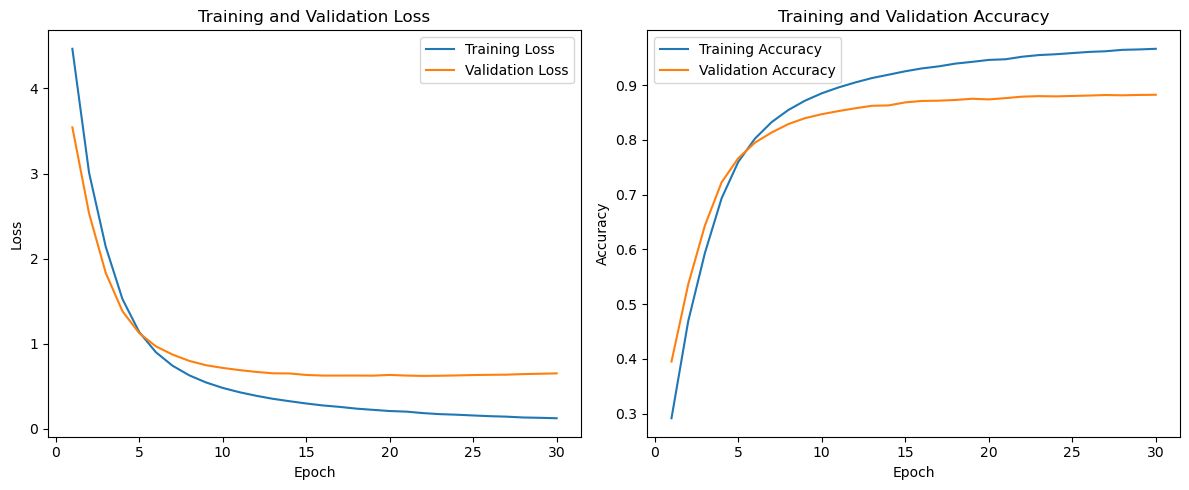

In [59]:
plot_training_history(history_df)

In [60]:
validation[16:25]

,italian,english_inp,english_out
16,proviamo a risolvere lindovinello,<start> let is try to solve the riddle,let is try to solve the riddle <end>
17,questa è la biro con cui ha firmato il documento,<start> this is the pen that he signed the doc...,this is the pen that he signed the document wi...
18,tom certamente non si aspettava di vincere,<start> tom certainly did not expect to win,tom certainly did not expect to win <end>
19,riesci a dormire,<start> can you sleep,can you sleep <end>
20,non riguarda noi,<start> it is not about us,it is not about us <end>
21,boston sta cambiando,<start> boston is changing,boston is changing <end>
22,il rosso è migliore,<start> red is better,red is better <end>
23,tom non ci lascerà aiutare mary,<start> tom will not let us help mary,tom will not let us help mary <end>
24,un elicottero girava in tondo sopra di noi,<start> a helicopter circled over us,a helicopter circled over us <end>


In [61]:
predicted = predict_with_attention('non riguarda noi')
print(predicted)

it is not about us


### 7. Visualization (attention heatmaps)

In [44]:
def plot_attention(input_sentence, output_sentence, attention):
    """
    Plots attention weights.

    Args:
        input_sentence (str): the original input sentence.
        output_sentence (str): the predicted output sentence.
        attention (np.array): attention matrix (target_len, input_len).
    """
    # Getting the italian and english tokens and storing it in a list
    input_tokens = input_sentence.lower().split()
    output_tokens = output_sentence.lower().split()

    # Initiate the figure size and the subplot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Trim attention to actual sequence lengths
    attention = attention[:len(output_tokens), :len(input_tokens)]

    #plotting it
    ax.matshow(attention, cmap='viridis')

    #font size
    fontdict = {'fontsize': 14}

    # adding the number of x and y ticks based on the length of tokens
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    # adding the actual words to the ticks
    ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(output_tokens, fontdict=fontdict)

    # adjusting the location
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # X and y labels
    ax.set_xlabel('Input Sentence')
    ax.set_ylabel('Predicted Output')
    # Showing the plot
    plt.show()
    

In [45]:
# prediction
output_sentence, attention_weights = predict_with_attention('non riguarda noi', return_attention=True)
print(output_sentence)

it is not about us


<Figure size 1000x800 with 0 Axes>

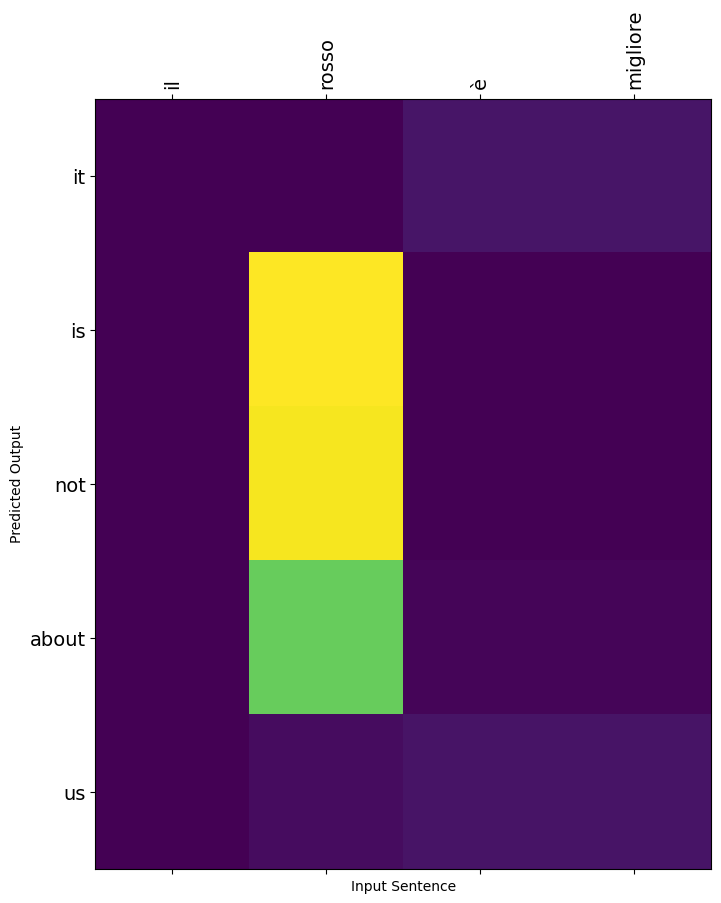

In [46]:
# Plotting
plot_attention('il rosso è migliore', output_sentence, attention_weights)

Bleu score is 65.8%, it improved! 

### 8. Use different scoring methods and show results

#### 8.1 Using general scoring method

In [47]:
# Loading the model
model_attention = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng, scoring_function='general', att_units =256)

/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_attention.compile(optimizer=optimizer,loss=masked_loss,metrics=[masked_acc])

In [49]:
# using checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # or 'best_model.h5'
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Using logger callback for plotting
csv_logger = CSVLogger('training_log_attention_general.csv', append=False)

In [50]:
# Fitting the model
model_attention.fit(ds_train,
          epochs=30,
          validation_data=ds_validate,
          verbose = 1,
          callbacks=[checkpoint, csv_logger])

Epoch 1/30


I0000 00:00:1746779703.371292     701 service.cc:152] XLA service 0x7efc08006100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746779703.371326     701 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1746779706.740409     701 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746779721.122370     701 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1180/1180 ━━━━━━━━━━━━━━━━━━━━ 155s 101ms/step - loss: 5.2818 - masked_acc: 0.2265 - val_loss: 3.5625 - val_masked_acc: 0.3960
Epoch 2/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step - loss: 3.2636 - masked_acc: 0.4378 - val_loss: 2.4039 - val_masked_acc: 0.5571
Epoch 3/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 88s 75ms/step - loss: 2.1936 - masked_acc: 0.5887 - val_loss: 1.7167 - val_masked_acc: 0.6649
Epoch 4/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 86s 72ms/step - loss: 1.5457 - masked_acc: 0.6929 - val_loss: 1.3195 - val_masked_acc: 0.7366
Epoch 5/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 89s 75ms/step - loss: 1.1676 - masked_acc: 0.7575 - val_loss: 1.1010 - val_masked_acc: 0.7740
Epoch 6/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 87s 73ms/step - loss: 0.9811 - masked_acc: 0.7881 - val_loss: 0.9752 - val_masked_acc: 0.7951
Epoch 7/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 87s 74ms/step - loss: 0.7867 - masked_acc: 0.8245 - val_loss: 0.8787 - val_masked_acc: 0.8131
Epoch 8/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step -

In [51]:
# Saving the model for future use
model_attention.save_weights("model_attention_general.weights.h5")

In [54]:
# getting 1000 values and taking the average Bleu
bleu_increment = 0
for row in validation[:1000].values:
    reference = row[2][:-6] # the original
    translation = predict_with_attention(row[0]) # traslated using model
    reference_tokens = reference.split()         # original tokens for bleu
    translation_tokens = translation.split()     # translated tokens for bleu

    #getting the bleu score
    bleu_score = sentence_bleu([reference_tokens], translation_tokens, smoothing_function=smoothie)
    #increment it to get average
    bleu_increment += bleu_score
    #Bleu score for the sentence
    print('BLEU score:', bleu_score)

BLEU score: 0.10754421249521595
BLEU score: 0.044706344276931285
BLEU score: 0.1901696869733609
BLEU score: 0.668740304976422
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.8091067115702212
BLEU score: 0.027383594129005207
BLEU score: 0.08621454270909737
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.08621454270909737
BLEU score: 0.04096772609215166
BLEU score: 1.0
BLEU score: 0.20381118070530826
BLEU score: 1.0
BLEU score: 0.09744264611591712
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.13414195051824768
BLEU score: 0.5156626918239822
BLEU score: 0.10873134470594509
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.668740304976422
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.07161190261650083
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.668740304976422
BLEU score: 0.299509

In [55]:
print('average BLEU score: ', bleu_increment/1000)

average BLEU score:  0.6666493127521042


In [56]:
# Load the CSVLogger output
history_df = pd.read_csv('training_log_attention_general.csv')

# Shift epoch index to start from 1 (optional, for consistency with manual logs)
history_df['epoch'] = history_df.index + 1

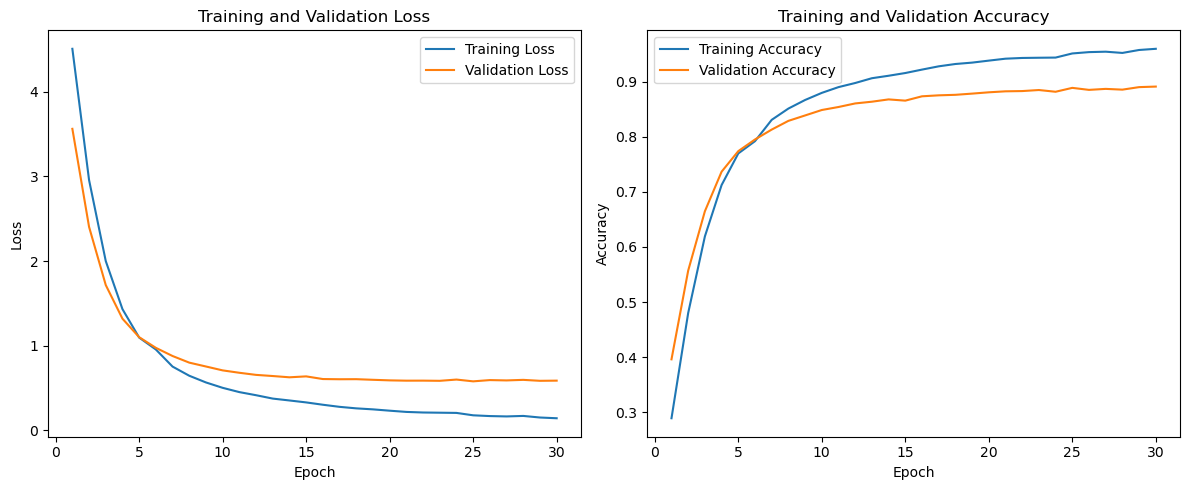

In [59]:
#plotting
plot_training_history(history_df)

In [60]:
#preview
validation[25:35]

,italian,english_inp,english_out
25,quello di cui ho bisogno adesso è dormire un po,<start> what i need to do now is get some sleep,what i need to do now is get some sleep <end>
26,tom era pazzo sa,<start> tom was crazy you know,tom was crazy you know <end>
27,tom è preparato,<start> tom is prepared,tom is prepared <end>
28,ora aprite gli occhi,<start> now open your eyes,now open your eyes <end>
29,tom è stato salvato da un passante,<start> tom was rescued by a passerby,tom was rescued by a passerby <end>
30,io non capisco che cosa sta dicendo,<start> i do not understand what you are saying,i do not understand what you are saying <end>
31,non perdiamo spesso,<start> we do not lose often,we do not lose often <end>
32,non voglio discutere dei problemi di tom con te,<start> i do not want to discuss tom is proble...,i do not want to discuss tom is problems with ...
33,cè qualcosa là fuori,<start> is there something out there,is there something out there <end>
34,io non ho niente da fare oggi,<start> i have nothing to do today,i have nothing to do today <end>


In [61]:
# Using the same predict Function
output_sentence, attention_weights = predict_with_attention('ora aprite gli occhi', return_attention=True)
print(output_sentence)

now open your eyes


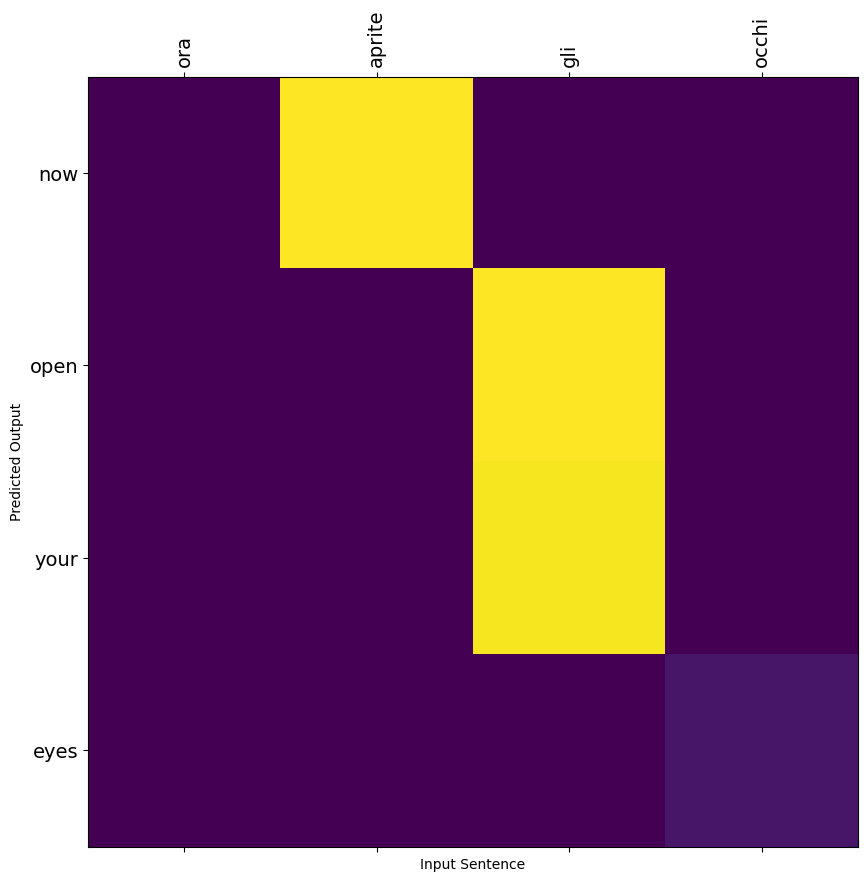

In [62]:
plot_attention('ora aprite gli occhi', output_sentence, attention_weights)

improved to 66.6%

#### 8.2 Using concat scoring method

In [63]:
# Initialize model object
model_attention = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng, scoring_function='concat', att_units =256)

/home/sherif/miniconda3/envs/deep_learning/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [64]:
# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_attention.compile(optimizer=optimizer,loss=masked_loss,metrics=[masked_acc])

In [65]:
# using checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # or 'best_model.h5'
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Using logger callback for plotting
csv_logger = CSVLogger('training_log_attention_concat.csv', append=False)

In [66]:
# Fit the model
model_attention.fit(ds_train,
          epochs=30,
          validation_data=ds_validate,
          verbose = 1,
          callbacks=[checkpoint, csv_logger])

Epoch 1/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 159s 105ms/step - loss: 5.2732 - masked_acc: 0.2294 - val_loss: 3.5795 - val_masked_acc: 0.3932
Epoch 2/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - loss: 3.3084 - masked_acc: 0.4306 - val_loss: 2.4564 - val_masked_acc: 0.5502
Epoch 3/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 89s 75ms/step - loss: 2.2119 - masked_acc: 0.5906 - val_loss: 1.6388 - val_masked_acc: 0.6844
Epoch 4/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - loss: 1.4739 - masked_acc: 0.7103 - val_loss: 1.2419 - val_masked_acc: 0.7500
Epoch 5/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - loss: 1.0799 - masked_acc: 0.7761 - val_loss: 1.0146 - val_masked_acc: 0.7903
Epoch 6/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - loss: 0.8484 - masked_acc: 0.8160 - val_loss: 0.8841 - val_masked_acc: 0.8147
Epoch 7/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 89s 75ms/step - loss: 0.6983 - masked_acc: 0.8430 - val_loss: 0.8007 - val_masked_acc: 0.8297
Epoch 8/30
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 89s 

In [67]:
# Saving the model for future use
model_attention.save_weights("model_attention_concat.weights.h5")

In [68]:
# getting 1000 values and taking the average Bleu
bleu_increment = 0
for row in validation[:1000].values:
    reference = row[2][:-6] # the original
    translation = predict_with_attention(row[0]) # traslated using model
    reference_tokens = reference.split()         # original tokens for bleu
    translation_tokens = translation.split()     # translated tokens for bleu

    #getting the bleu score
    bleu_score = sentence_bleu([reference_tokens], translation_tokens, smoothing_function=smoothie)
    #increment it to get average
    bleu_increment += bleu_score
    #Bleu score for the sentence
    print('BLEU score:', bleu_score)

BLEU score: 1.0
BLEU score: 0.18616487055295167
BLEU score: 0.18911927569170678
BLEU score: 0.17141814854755813
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.06302647598688789
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.04871911135426937
BLEU score: 0.07249749990681824
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.12300543931351683
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.5757197301274735
BLEU score: 0.5757197301274735
BLEU score: 1.0
BLEU score: 0.10754421249521595
BLEU score: 1.0
BLEU score: 0.23376641384792204
BLEU score: 0.09541207563138922
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.14414490662307036
BLEU score: 1.0
BLEU score: 0.3403088515262244
BLEU score: 1.0
BLEU score: 0.07948346282299562
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 1.0
BLEU score: 0.668740304976422
BLEU score: 0.43146827293898643
BLEU score: 0.21938699234088677


In [69]:
print('average BLEU score: ', bleu_increment/1000)

average BLEU score:  0.6677391257280366


In [70]:
# Load the CSVLogger output
history_df = pd.read_csv('training_log_attention_concat.csv')

# Shift epoch index to start from 1 (optional, for consistency with manual logs)
history_df['epoch'] = history_df.index + 1

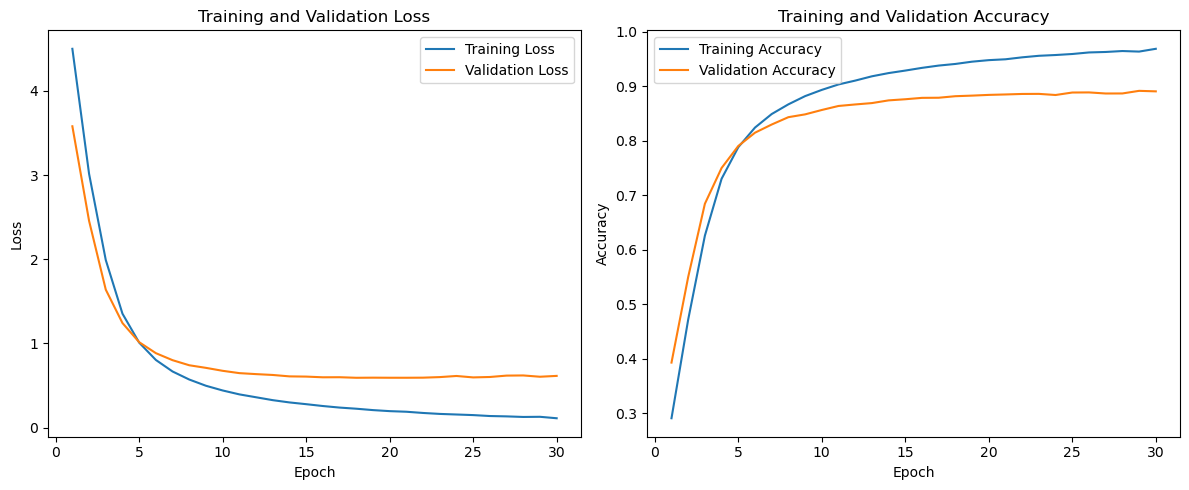

In [71]:
#plotting
plot_training_history(history_df)

In [72]:
#preview
validation[35:45]

,italian,english_inp,english_out
35,di solito vado al lavoro in bici o in autobus,<start> usually i cycle or get the bus to work,usually i cycle or get the bus to work <end>
36,lo so che tom era il tuo migliore amico,<start> i know tom was your best friend,i know tom was your best friend <end>
37,io pensavo che la partita fosse finita,<start> i thought the game was over,i thought the game was over <end>
38,voi non ceravate nemmeno,<start> you were not even there,you were not even there <end>
39,sono sul ponte,<start> i am on the deck,i am on the deck <end>
40,lho scritta di persona,<start> i wrote it myself,i wrote it myself <end>
41,lacqua del rubinetto è sicura da bere,<start> is tap water safe to drink,is tap water safe to drink <end>
42,loro ci vendono del rame,<start> they sell us copper,they sell us copper <end>
43,tom perderà tutto,<start> tom is going to lose everything,tom is going to lose everything <end>
44,tom comprò un paio di orecchini per mary,<start> tom bought a pair of earrings for mary,tom bought a pair of earrings for mary <end>


In [74]:
# Using the same predict Function
output_sentence, attention_weights = predict_with_attention('lo so che tom era il tuo migliore amico', return_attention=True)
print(output_sentence)

i know tom was your best friend


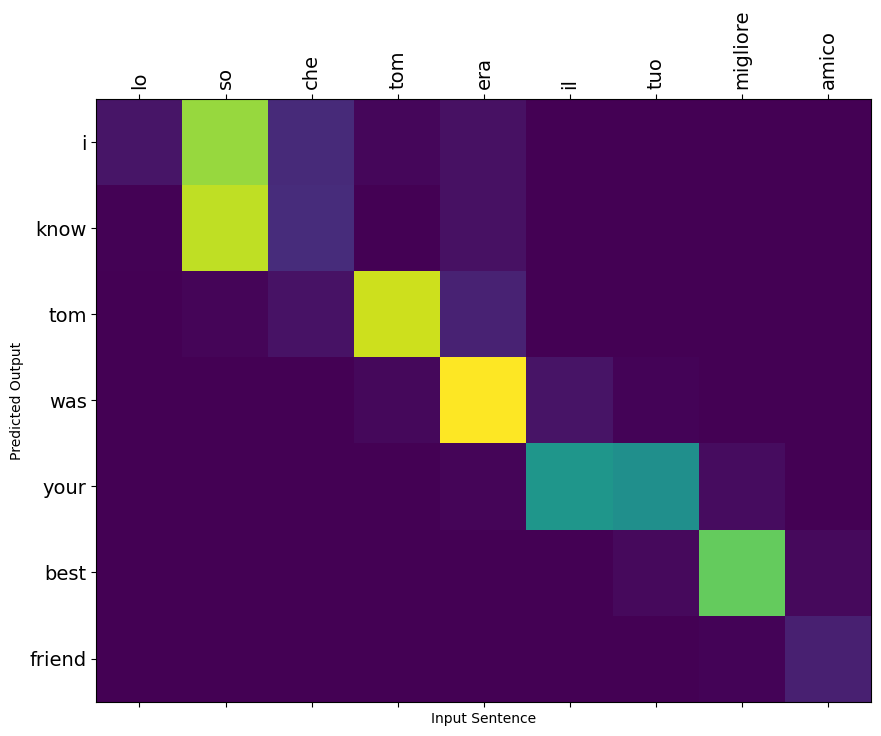

In [75]:
plot_attention('lo so che tom era il tuo migliore amico', output_sentence, attention_weights)

small improvement to 66.8%

## Evaluation & Results

We evaluated multiple encoder-decoder architectures on the translation task using BLEU score and attention visualization:

| Model Variant                               | BLEU Score |
|---------------------------------------------|------------|
| Encoder-Decoder (no attention)              | 60.8       |
| Encoder-Decoder + Attention (dot scoring)   | 65.8       |
| Encoder-Decoder + Attention (general scoring)| 66.6       |
| Encoder-Decoder + Attention (concat scoring)| 66.8       |

### Observations:
- Adding attention significantly improved translation quality over the baseline model.
- Among attention mechanisms, **concatenation scoring** yielded the highest BLEU score.
- Attention plots also improved qualitatively with better alignment between source and target words as scoring methods advanced.

## Conclusion

In this project, I successfully implemented an encoder-decoder architecture with and without attention, exploring three different attention scoring methods: dot, general, and concatenation.

Key takeaways:
- Attention mechanisms significantly improved BLEU scores and translation quality compared to the baseline model.
- Among the scoring methods, **concatenation-based attention** performed best, both quantitatively (BLEU score) and qualitatively (attention alignment).
- This project deepened my understanding of sequence-to-sequence modeling, attention mechanics, and model evaluation using BLEU and visualizations.

Future work may include:
- Further improving the score
- Training on larger or multilingual datasets
- Exploring transformer-based architectures
- Integrating beam search decoding for improved output fluency

## References / Credits
- [Tensorflow Making new layers and models via subclassing:](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)
- [Tensorflow Neural machine translation with attention:](https://www.tensorflow.org/text/tutorials/nmt_with_attention#the_attention_layer)
- [Jay Alammar Visualizing A Neural Machine Translation Model:](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
- [glove.6B.100d Used](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.100d.txt)
- [Research Paper: NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE:](https://arxiv.org/pdf/1409.0473)
- [Research Paper: Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025)